# 잡음제거 오토인코더 모델

## 1. 메모리를 아끼는 데이터 로드

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# from tensorflow.keras.layers import *

In [7]:
# 파일 경로 불러오기
ORG_DATA_PATH = './Dataset/Original/'
NIS_DATA_PATH = './Dataset/Noisy/'
filepaths = os.listdir(ORG_DATA_PATH)

In [56]:
class Dataset(tf.keras.utils.Sequence):
    """ keras에 Sequence 클래스를 상속받아
    batchsize 만큼만 이미지를 load하는 DataLoader를 설계"""
    def __init__(self,
                 org_path,
                 nis_path,
                 filepaths,
                 batch_size=32,
                 target_size=(256,256),
                 shuffle=True):
        self.org_path = org_path
        self.nis_path = nis_path
        self.filepaths = filepaths
        self.batch_size = batch_size
        self.target_size = target_size
        if shuffle:
            np.random.shuffle(self.filepaths)
            
    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.filepaths))
        
        self.x = []
        self.y = []
        for p in self.filepaths[low:high]:
            # load
            org_img = cv2.imread(os.path.join(self.org_path, p))
            nis_img = cv2.imread(os.path.join(self.nis_path, p))
            # resize
            org_img = cv2.resize(org_img, dsize=self.target_size)
            nis_img = cv2.resize(nis_img, dsize=self.target_size)
            # scaling
            org_img = np.divide(org_img, 255.)
            nis_img = np.divide(nis_img, 255.)
            
            self.x.append(nis_img)
            self.y.append(org_img)
            
        return np.array(self.x), np.array(self.y)
            
    def __len__(self):
        return int(np.ceil(len(self.filepaths)//self.batch_size))

In [58]:
# 설계한 대로 데이터셋 선언
dataset = Dataset(org_path=ORG_DATA_PATH,
                 nis_path=NIS_DATA_PATH,
                 filepaths=filepaths)

In [59]:
# 올바르게 로드하는지 테스트
x,y = next(iter(dataset))

(-0.5, 255.5, 255.5, -0.5)

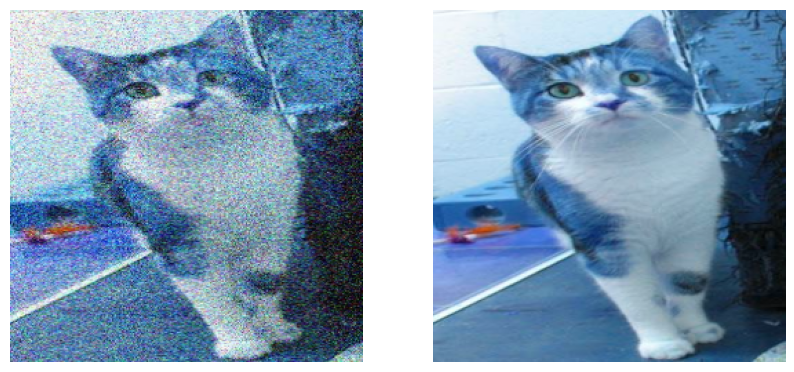

In [60]:
sample_x = x[2]
sample_y = y[2]
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(sample_x)
axes[1].imshow(sample_y)
axes[0].axis('off')
axes[1].axis('off')

In [61]:
# Sequence 방법과 일반 방법의 비교
x = []
y = []
for p in filepaths:
    # load
    org_img = cv2.imread(os.path.join(ORG_DATA_PATH, p))
    nis_img = cv2.imread(os.path.join(NIS_DATA_PATH, p))
    # resize
    org_img = cv2.resize(org_img, dsize=(256,256))
    nis_img = cv2.resize(nis_img, dsize=(256,256))
    # scaling
    org_img = np.divide(org_img, 255.)
    nis_img = np.divide(nis_img, 255.)

    x.append(nis_img)
    y.append(org_img)

In [62]:
del x,y

## 마들링

In [121]:
# modeling
input_layer = tf.keras.layers.Input(shape=(256,256,3))
## Encoder
x = tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, padding='same',
                          activation=None)(input_layer)
# x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same',
                          activation=None)(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same',
                          activation=None)(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
## Latent vector
latent = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                          activation=None)(x)
## Decoder
x = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3,strides=2,
                                   padding='same',
                                    activation=None)(x)
x = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3,strides=2,
                                   padding='same',
                                    activation=None)(x)
x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3,strides=2,
                                   padding='same',
                                   activation='sigmoid')(x)

model = tf.keras.models.Model(input_layer, x)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 128, 128, 8)       1160      
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 256, 256, 3)       219

In [122]:
model.compile(loss='mse', optimizer='adam')

In [123]:
model.fit(dataset, epochs=20)

Epoch 1/20
31/31 [==============================] - 6s 174ms/step - loss: 0.0676
Epoch 2/20
31/31 [==============================] - 6s 178ms/step - loss: 0.0305
Epoch 3/20
31/31 [==============================] - 6s 182ms/step - loss: 0.0131
Epoch 4/20
31/31 [==============================] - 6s 178ms/step - loss: 0.0103
Epoch 5/20
31/31 [==============================] - 6s 181ms/step - loss: 0.0094
Epoch 6/20
31/31 [==============================] - 6s 181ms/step - loss: 0.0088
Epoch 7/20
31/31 [==============================] - 6s 181ms/step - loss: 0.0082
Epoch 8/20
31/31 [==============================] - 6s 182ms/step - loss: 0.0068
Epoch 9/20
31/31 [==============================] - 6s 178ms/step - loss: 0.0059
Epoch 10/20
31/31 [==============================] - 6s 180ms/step - loss: 0.0054
Epoch 11/20
31/31 [==============================] - 6s 180ms/step - loss: 0.0052
Epoch 12/20
31/31 [==============================] - 6s 179ms/step - loss: 0.0050
Epoch 13/20
31/31 [======

(-0.5, 498.5, 374.5, -0.5)

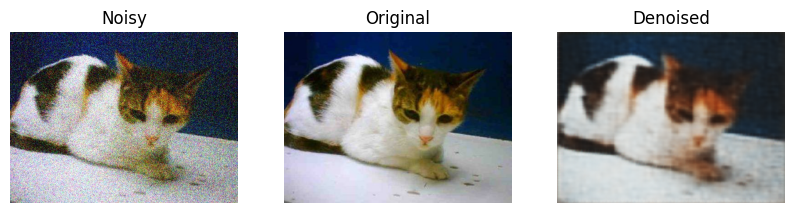

In [124]:
from functools import partial
# predict
rnd_idx = np.random.randint(0, len(filepaths), 1)[0]
noisy_smp = cv2.imread(os.path.join(NIS_DATA_PATH, filepaths[rnd_idx]))
org_smp = cv2.imread(os.path.join(ORG_DATA_PATH, filepaths[rnd_idx]))

input_img = cv2.resize(noisy_smp, (256,256))
input_img = np.divide(input_img, 255.)

denoised_img = model.predict(input_img[np.newaxis,...])
denoised_img = (denoised_img[0]*255.).astype(np.uint8)
denoised_img = cv2.resize(denoised_img, org_smp.shape[1::-1])

bgr2rgb = partial(cv2.cvtColor, code=cv2.COLOR_BGR2RGB)

# compare results
fig, axes = plt.subplots(1,3,figsize=(10,5))
axes[0].imshow(bgr2rgb(noisy_smp))
axes[1].imshow(bgr2rgb(org_smp))
axes[2].imshow(bgr2rgb(denoised_img))
axes[0].set_title('Noisy'); axes[0].axis('off')
axes[1].set_title('Original'); axes[1].axis('off')
axes[2].set_title('Denoised'); axes[2].axis('off')

* 위 결과에서 확인하실 수 있듯이 훈련된 잡음제거 모델이
    * 뿌려진 잡음은 효과적으로 제거하지만,
    * 그 과정에서 이미지의 선명도가 떨어지는 것을 확인하실 수 있습니다
    * 일종의 **저주파 통과 필터(lowpass filter)** 역할을 하는것이죠
* 여러분도 본인만의 모델을 훈련시켜, 선명도을 유지하면서 잡음을 제거하는 모델을 만들어보세요!
* 또한 기회가 된다면, 훈련되지 않은 데이터셋, 즉 검증데이터를 만들어 내는 `DataLoader` 역시 만들어보는 시도를 해보시면 좋은 경험이 될듯 합니다.